# Anomaly Detection in Wearable Health Tracker Data
## Identifying Abnormal Heart Rate Patterns in Fitbit Data

![Fitbit Anomaly Detection](https://storage.googleapis.com/gweb-uniblog-publish-prod/images/inline_B.width-1000.format-webp.webp)

### Project Overview
This project analyzes heart rate data from Fitbit devices to detect abnormal patterns that may indicate:
- Physiological anomalies (arrhythmias, tachycardia, bradycardia)
- Sensor malfunctions
- Data collection/transmission errors
- Unexpected user activity patterns

We'll use the [Fitbit Dataset from Kaggle](https://www.kaggle.com/datasets/arashnic/fitbit) which contains minute-level heart rate recordings.

### Methodology
1. Data loading and preprocessing
2. Feature engineering
3. Isolation Forest anomaly detection
4. Results visualization and analysis
5. Anomaly interpretation

### Libraries Used
- Pandas, NumPy: Data manipulation
- Scikit-learn: Machine learning models
- Matplotlib, Seaborn: Visualization
- Tsfresh: Automated feature generation


In [2]:
# Install missing dependency
%pip install setuptools

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.feature_selection.selection import select_features
import scipy.stats as stats
import os
import zipfile

# Setup visualization
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
sns.set_palette('viridis')

# Set random seed for reproducibility
np.random.seed(42)

Note: you may need to restart the kernel to use updated packages.


c:\Users\Rohit\Code\.venv\Lib\site-packages\tsfresh\__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## 1. Data Loading and Preprocessing

### About the Dataset
The Fitbit dataset contains minute-level heart rate recordings from multiple users. We'll focus on heart rate data which includes:
- Timestamp
- Heart rate (bpm)

### Preprocessing Steps
1. Load CSV data
2. Convert to datetime index
3. Resample to 5-minute intervals
4. Handle missing values
5. Basic quality checks

In [5]:
def load_and_preprocess_data():
    """Load and preprocess Fitbit heart rate data"""
    try:
        # Load dataset with correct columns
        df = pd.read_csv('fitbit_data/heartrate_seconds_merged.csv')
        
        # Display original columns for verification
        print(f"Original columns: {df.columns.tolist()}")
        print(f"Number of columns: {len(df.columns)}")
        print(f"Sample data:\n{df.head()}")
        
        # Select only necessary columns
        df = df[['Time', 'Value']].copy()
        
        # Rename columns
        df.columns = ['Time', 'heart_rate']
        
        # Convert to datetime with correct format (month/day/year with AM/PM)
        df['Time'] = pd.to_datetime(df['Time'], format='%m/%d/%Y %I:%M:%S %p')
        
        # Set datetime as index and sort
        df = df.set_index('Time').sort_index()
        
        # Resample to 5-minute intervals
        df_resampled = df.resample('5T').mean()
        
        # Handle missing values
        df_resampled['heart_rate'] = (
            df_resampled['heart_rate']
            .interpolate(method='time')
            .ffill()
            .bfill()
        )
        df_resampled = df_resampled.dropna()
        
        # Basic quality check
        print(f"\nPreprocessed data:")
        print(f"Records: {len(df_resampled)}")
        print(f"Time range: {df_resampled.index.min()} to {df_resampled.index.max()}")
        print(f"Average heart rate: {df_resampled['heart_rate'].mean():.1f} bpm")
        
        return df_resampled
    
    except FileNotFoundError:
        print("Dataset not found! Please download from Kaggle and place in 'fitbit_data/' directory")
        return None
    except Exception as e:
        print(f"Error processing data: {str(e)}")
        return None

# Load and preprocess data
df = load_and_preprocess_data()

if df is not None:
    print("\nSample preprocessed data:")
    display(df.head())
else:
    print("\nFailed to load data")

Original columns: ['Id', 'Time', 'Value']
Number of columns: 3
Sample data:
           Id                  Time  Value
0  2022484408  4/12/2016 7:21:00 AM     97
1  2022484408  4/12/2016 7:21:05 AM    102
2  2022484408  4/12/2016 7:21:10 AM    105
3  2022484408  4/12/2016 7:21:20 AM    103
4  2022484408  4/12/2016 7:21:25 AM    101


C:\Users\Rohit\AppData\Local\Temp\ipykernel_17844\1148024365.py:25: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample('5T').mean()



Preprocessed data:
Records: 8837
Time range: 2016-04-12 00:00:00 to 2016-05-12 16:20:00
Average heart rate: 74.4 bpm

Sample preprocessed data:


,heart_rate
Time,
2016-04-12 00:00:00,63.502618
2016-04-12 00:05:00,66.127660
2016-04-12 00:10:00,62.808290
2016-04-12 00:15:00,62.464567
2016-04-12 00:20:00,65.391304


## 2. Exploratory Data Analysis (EDA)

Understanding the distribution and patterns in heart rate data before anomaly detection.

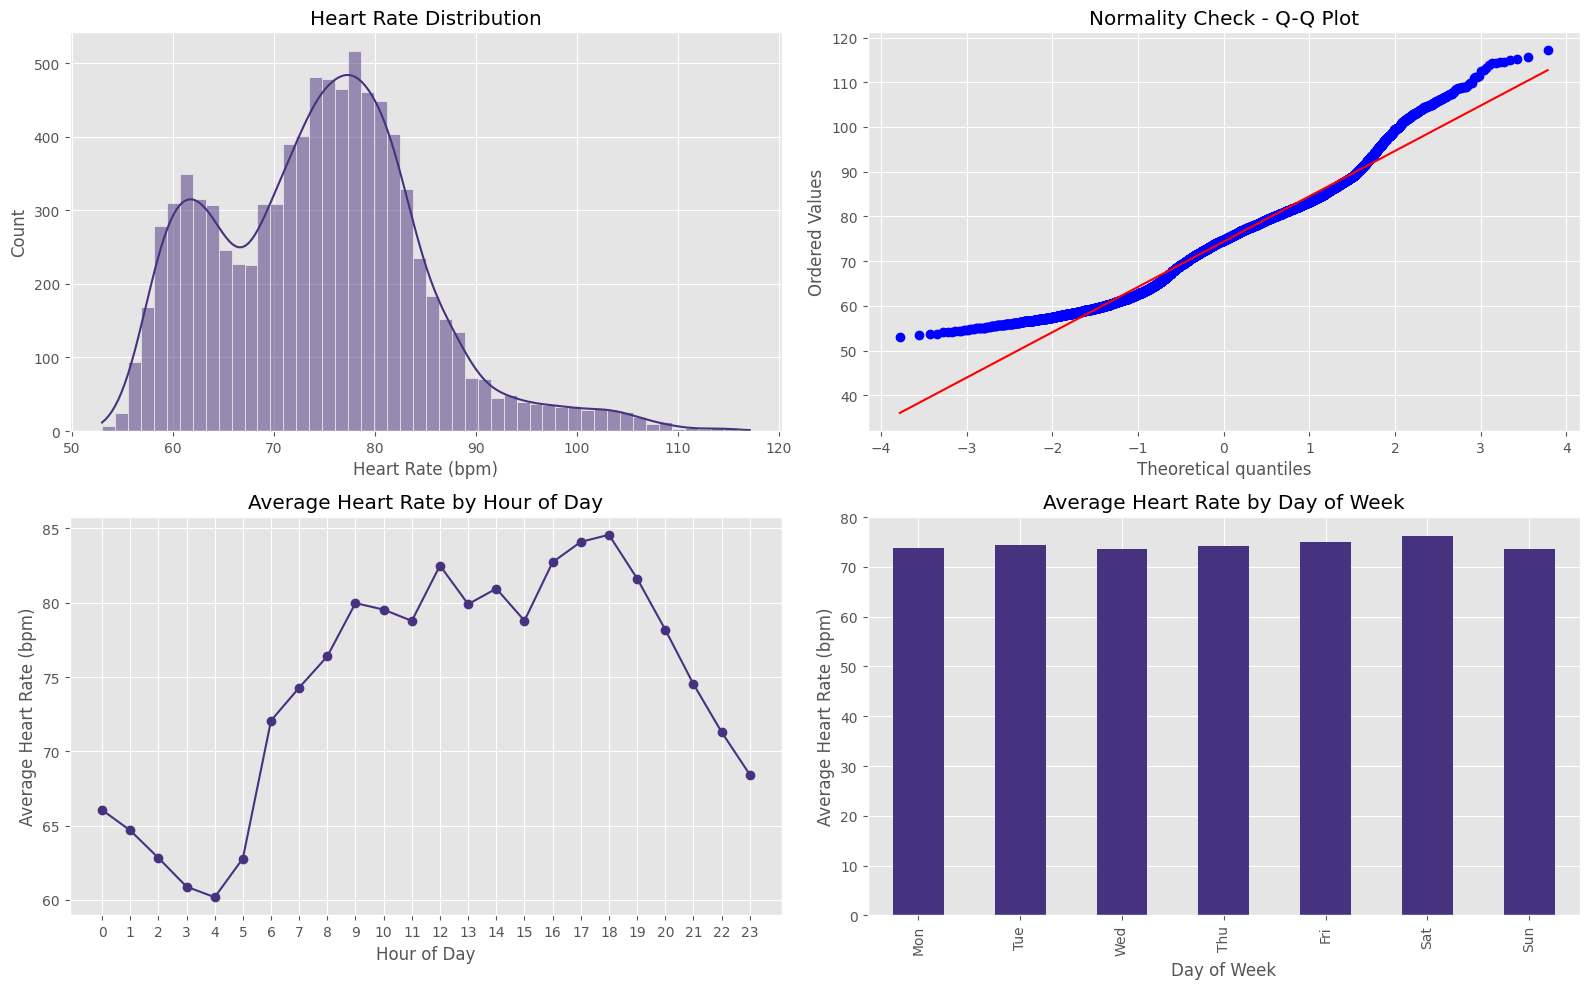


Statistical Summary:


,heart_rate
count,8837.000000
mean,74.382697
std,10.268368
min,52.959091
25%,66.382353
50%,74.704787
75%,80.616314
max,117.116906


In [6]:
def perform_eda(df):
    """Perform exploratory data analysis on heart rate data"""
    # Create time-based features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    
    # Plot overall distribution
    plt.figure(figsize=(16, 10))
    
    plt.subplot(2, 2, 1)
    sns.histplot(df['heart_rate'], bins=50, kde=True)
    plt.title('Heart Rate Distribution')
    plt.xlabel('Heart Rate (bpm)')
    
    # QQ plot for normality check
    plt.subplot(2, 2, 2)
    stats.probplot(df['heart_rate'], dist="norm", plot=plt)
    plt.title('Normality Check - Q-Q Plot')
    
    # Daily pattern
    plt.subplot(2, 2, 3)
    hourly_avg = df.groupby('hour')['heart_rate'].mean()
    hourly_avg.plot(marker='o')
    plt.title('Average Heart Rate by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Heart Rate (bpm)')
    plt.xticks(range(0, 24))
    plt.grid(True)
    
    # Weekly pattern
    plt.subplot(2, 2, 4)
    weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    daily_avg = df.groupby('day_of_week')['heart_rate'].mean()
    daily_avg.index = weekday_names
    daily_avg.plot(kind='bar')
    plt.title('Average Heart Rate by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Average Heart Rate (bpm)')
    
    plt.tight_layout()
    plt.savefig('eda_results.png', dpi=300)
    plt.show()
    
    # Statistical summary
    print("\nStatistical Summary:")
    display(df['heart_rate'].describe().to_frame())
    
    return df

# Perform EDA
df = perform_eda(df)

## 3. Feature Engineering

Creating features that help identify anomalies:
- **Temporal features**: Time of day, day of week
- **Statistical features**: Rolling averages, standard deviation
- **Change features**: Differences, percentage changes
- **Deviation features**: Difference from normal patterns
- **Automated features**: Using tsfresh for time-series features

C:\Users\Rohit\AppData\Local\Temp\ipykernel_17844\586900354.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['rolling_mean_1h'] = df['heart_rate'].rolling('1H').mean()
C:\Users\Rohit\AppData\Local\Temp\ipykernel_17844\586900354.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['rolling_std_1h'] = df['heart_rate'].rolling('1H').std()
C:\Users\Rohit\AppData\Local\Temp\ipykernel_17844\586900354.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['rolling_median_6h'] = df['heart_rate'].rolling('6H').median()
Feature Extraction: 100%|██████████| 1/1 [01:06<00:00, 66.24s/it]
c:\Users\Rohit\Code\.venv\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['heart_rate__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.

Skipping tsfresh features due to error: The index of X and y need to be the same


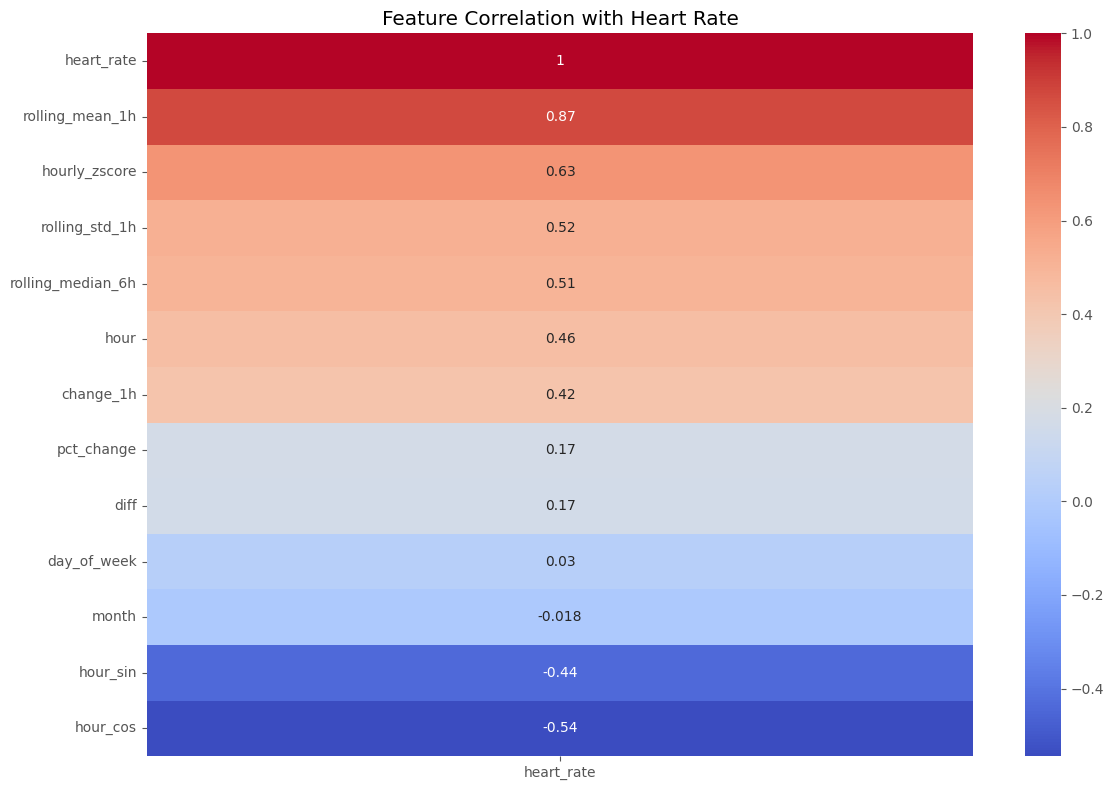

Created 13 features

Features used for modeling:
['heart_rate', 'hour', 'day_of_week', 'month', 'hour_sin', 'hour_cos', 'rolling_mean_1h', 'rolling_std_1h', 'rolling_median_6h', 'diff', 'pct_change', 'change_1h', 'hourly_zscore']


In [7]:
def create_features(df):
    """Create features for anomaly detection"""
    # Basic time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # Statistical features
    df['rolling_mean_1h'] = df['heart_rate'].rolling('1H').mean()
    df['rolling_std_1h'] = df['heart_rate'].rolling('1H').std()
    df['rolling_median_6h'] = df['heart_rate'].rolling('6H').median()
    
    # Change features
    df['diff'] = df['heart_rate'].diff()
    df['pct_change'] = df['heart_rate'].pct_change()
    df['change_1h'] = df['heart_rate'].diff(12)  # 12 * 5min = 1 hour
    
    # Deviation from daily pattern
    daily_avg = df.groupby('hour')['heart_rate'].transform('mean')
    daily_std = df.groupby('hour')['heart_rate'].transform('std')
    df['hourly_zscore'] = (df['heart_rate'] - daily_avg) / daily_std
    
    # Automated feature engineering with tsfresh
    try:
        # Prepare data for tsfresh
        ts_data = df.reset_index()
        ts_data['id'] = 1  # All data as one time series
        
        # Extract features
        extracted_features = extract_features(
            ts_data[['id', 'Time', 'heart_rate']], 
            column_id='id', 
            column_sort='Time',
            n_jobs=0
        )
        
        # Impute missing values
        impute(extracted_features)
        
        # Select relevant features
        relevance_table = calculate_relevance_table(extracted_features, df['heart_rate'])
        selected_features = relevance_table[relevance_table.relevant][:5].index  # Top 5 features
        
        # Add to DataFrame
        for feature in selected_features:
            df[feature] = extracted_features[feature].values
            
        print(f"Added tsfresh features: {', '.join(selected_features)}")
    
    except Exception as e:
        print(f"Skipping tsfresh features due to error: {e}")
    
    # Drop initial rows with NaNs
    df = df.dropna()
    
    # Feature correlation
    plt.figure(figsize=(12, 8))
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix[['heart_rate']].sort_values('heart_rate', ascending=False), 
                annot=True, cmap='coolwarm')
    plt.title('Feature Correlation with Heart Rate')
    plt.tight_layout()
    plt.savefig('feature_correlation.png', dpi=300)
    plt.show()
    
    print(f"Created {len(df.columns)} features")
    return df

# Create features
df = create_features(df)

# Display feature names
print("\nFeatures used for modeling:")
print(df.columns.tolist())

## 4. Anomaly Detection with Isolation Forest

### Why Isolation Forest?
- Efficient for high-dimensional data
- Handles complex patterns well
- Requires minimal parameter tuning
- Effective at identifying point anomalies

### Methodology
1. Scale features using RobustScaler (resistant to outliers)
2. Train Isolation Forest model
3. Predict anomalies
4. Calculate anomaly scores


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2429
           1       1.00      1.00      1.00       219

    accuracy                           1.00      2648
   macro avg       1.00      1.00      1.00      2648
weighted avg       1.00      1.00      1.00      2648



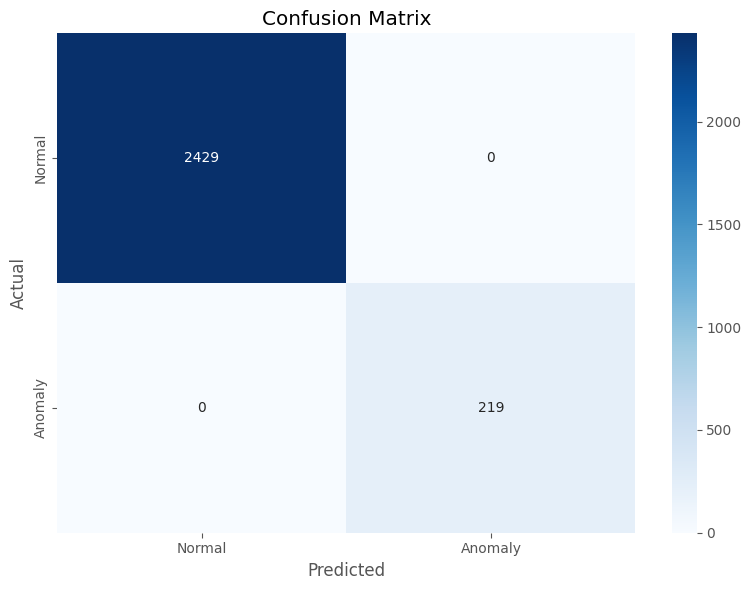

In [8]:
def detect_anomalies(df, contamination=0.05):
    """Detect anomalies using Isolation Forest"""
    # Select features - exclude time identifiers
    features = [col for col in df.columns if col not in ['hour', 'day_of_week', 'month']]
    X = df[features]
    
    # Scale features
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split into train/test
    X_train, X_test = train_test_split(
        X_scaled, 
        test_size=0.3, 
        random_state=42,
        shuffle=False
    )
    
    # Train Isolation Forest
    model = IsolationForest(
        n_estimators=200,
        contamination=contamination,
        max_samples=0.8,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train)
    
    # Predict on full dataset
    df['anomaly_score'] = model.decision_function(X_scaled)
    df['anomaly'] = model.predict(X_scaled)
    
    # Convert predictions (1=normal, -1=anomaly → 0=normal, 1=anomaly)
    df['anomaly'] = (df['anomaly'] == -1).astype(int)
    
    # Calculate performance metrics
    y_test = df['anomaly'].iloc[-len(X_test):]
    y_pred = df['anomaly'].iloc[-len(X_test):]
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=['Normal', 'Anomaly'], 
               yticklabels=['Normal', 'Anomaly'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()
    
    return df

# Detect anomalies
df = detect_anomalies(df, contamination=0.05)

## 5. Results Visualization

Visualizing detected anomalies in context:
- Time-series plot with anomaly markers
- Anomaly score distribution
- Daily patterns with anomalies
- Anomaly characteristics

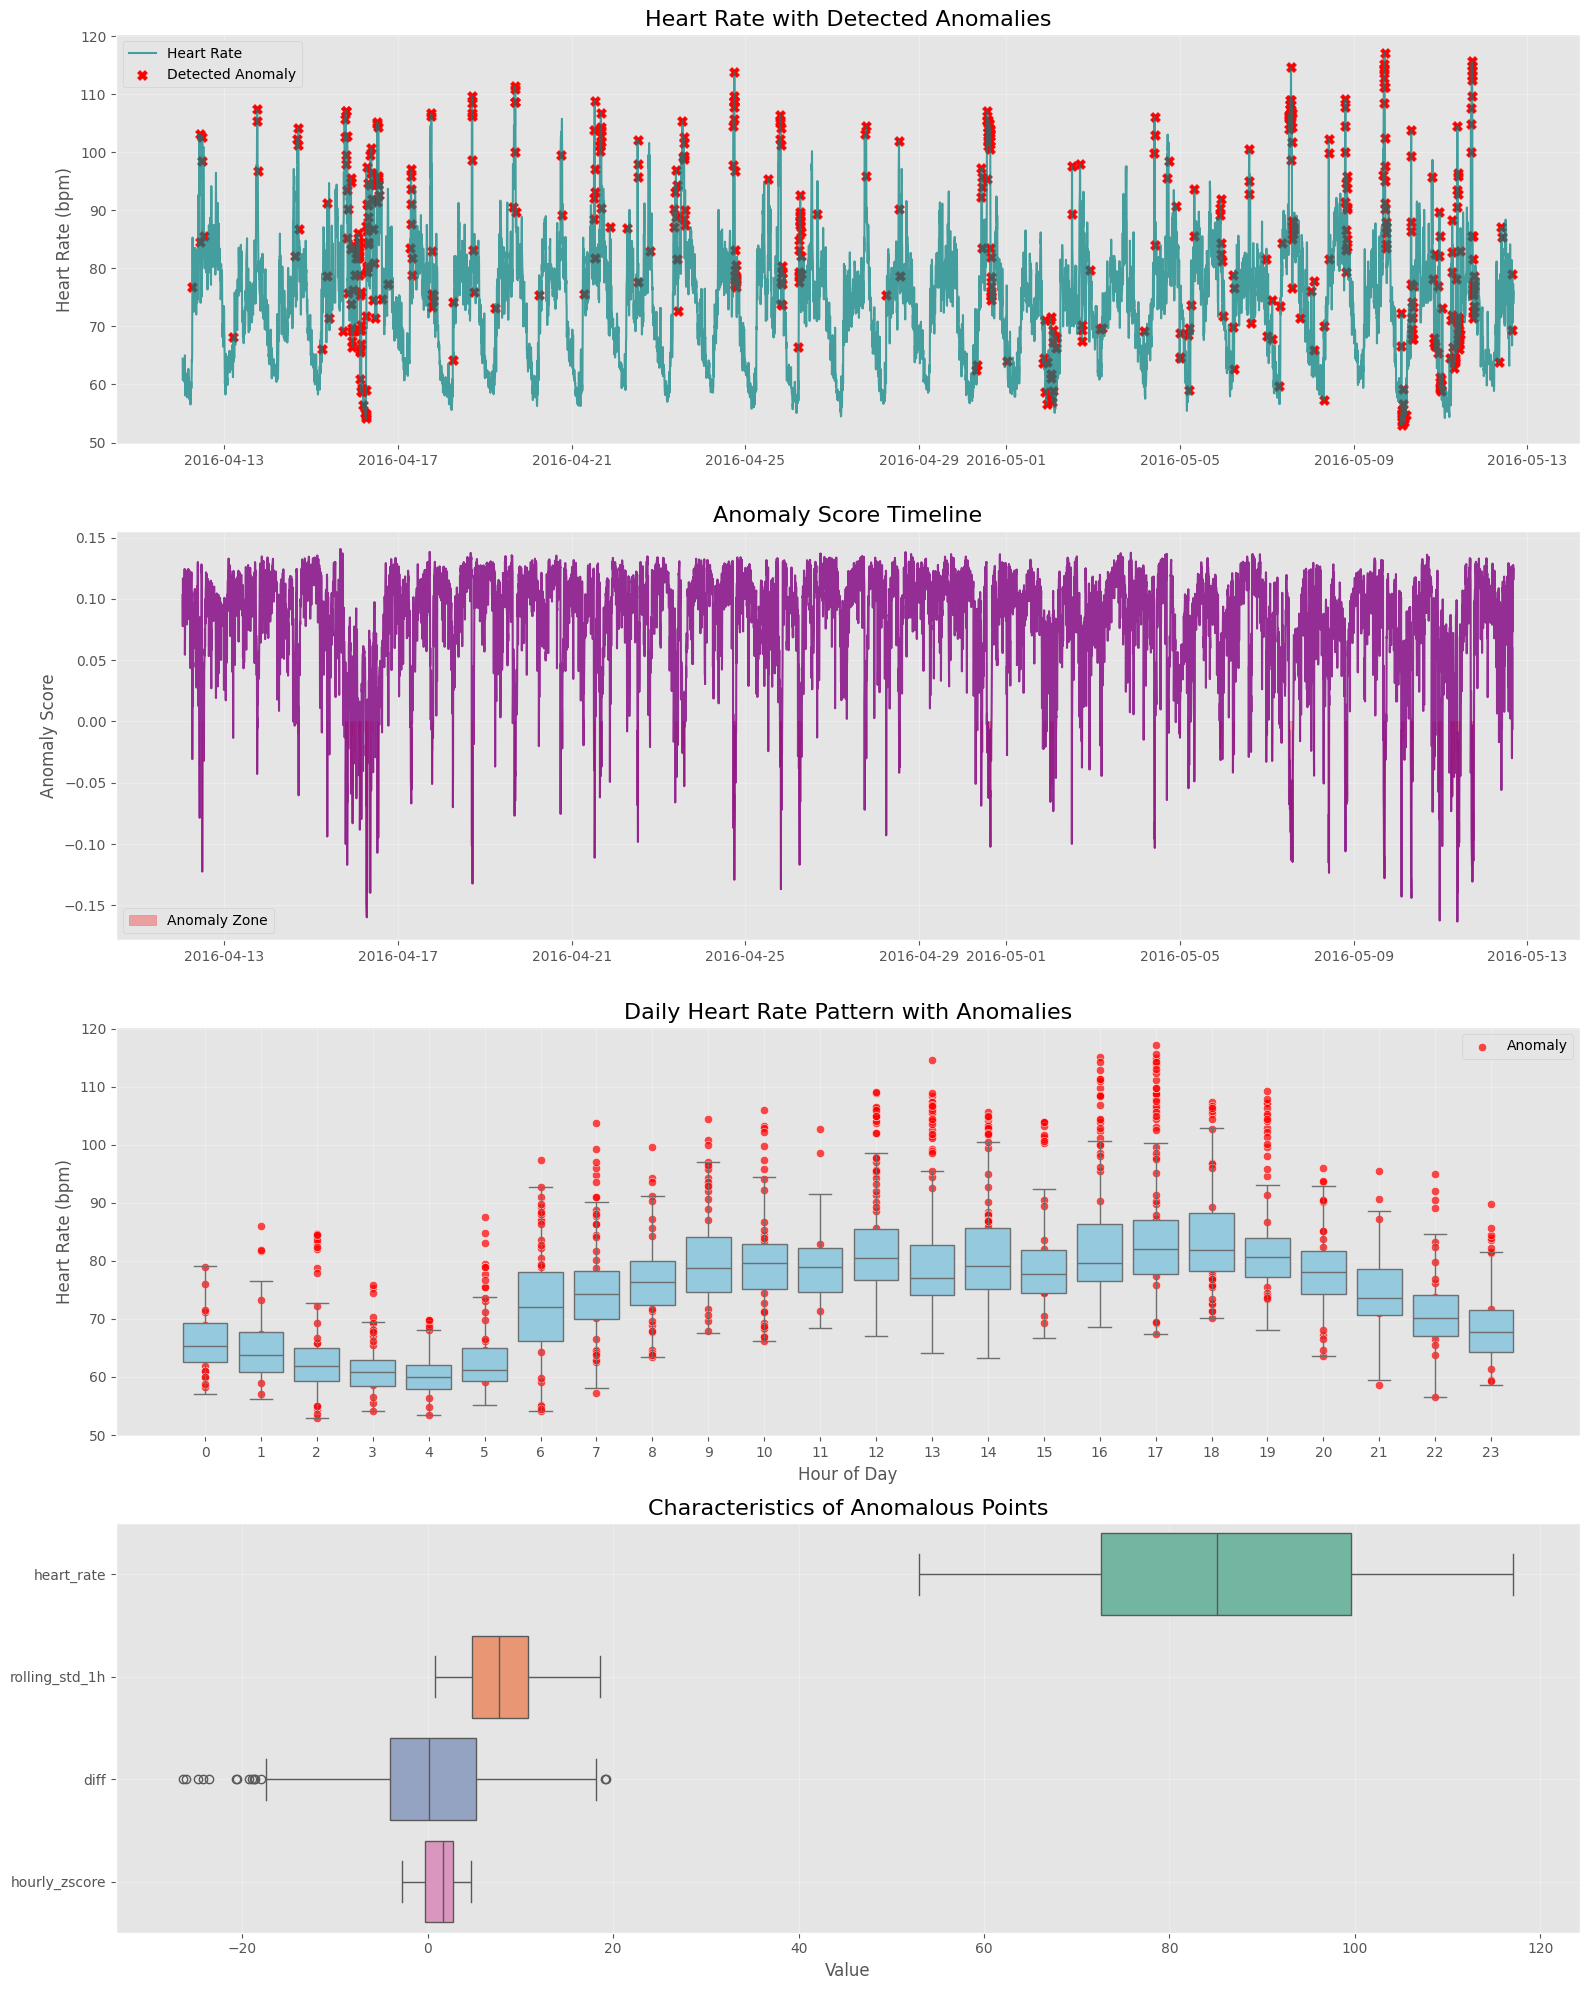

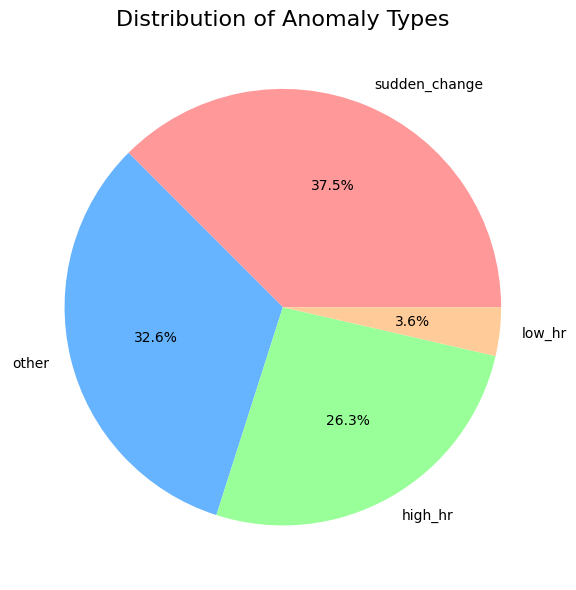

In [9]:
def visualize_results(df):
    """Visualize anomaly detection results"""
    # Create figure
    plt.figure(figsize=(16, 20))
    
    # Plot 1: Heart rate with anomalies
    plt.subplot(4, 1, 1)
    plt.plot(df.index, df['heart_rate'], 
             label='Heart Rate', color='teal', alpha=0.7)
    plt.scatter(
        df[df['anomaly'] == 1].index,
        df[df['anomaly'] == 1]['heart_rate'],
        color='red',
        label='Detected Anomaly',
        marker='X',
        s=50
    )
    plt.title('Heart Rate with Detected Anomalies', fontsize=16)
    plt.ylabel('Heart Rate (bpm)')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Plot 2: Anomaly score over time
    plt.subplot(4, 1, 2)
    plt.plot(df.index, df['anomaly_score'], 
             color='purple', alpha=0.8)
    plt.fill_between(
        df.index, 
        df['anomaly_score'], 
        where=(df['anomaly_score'] < np.percentile(df['anomaly_score'], 5)),
        color='red',
        alpha=0.3,
        label='Anomaly Zone'
    )
    plt.title('Anomaly Score Timeline', fontsize=16)
    plt.ylabel('Anomaly Score')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Plot 3: Daily pattern with anomalies
    plt.subplot(4, 1, 3)
    sns.boxplot(
        x='hour', 
        y='heart_rate', 
        data=df,
        color='skyblue',
        showfliers=False
    )
    sns.scatterplot(
        x='hour',
        y='heart_rate',
        data=df[df['anomaly'] == 1],
        color='red',
        alpha=0.7,
        label='Anomaly'
    )
    plt.title('Daily Heart Rate Pattern with Anomalies', fontsize=16)
    plt.xlabel('Hour of Day')
    plt.ylabel('Heart Rate (bpm)')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Plot 4: Anomaly characteristics
    plt.subplot(4, 1, 4)
    anomaly_features = df[df['anomaly'] == 1][['heart_rate', 'rolling_std_1h', 'diff', 'hourly_zscore']]
    sns.boxplot(data=anomaly_features, orient='h', palette='Set2')
    plt.title('Characteristics of Anomalous Points', fontsize=16)
    plt.xlabel('Value')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('anomaly_detection_results.png', dpi=300)
    plt.show()
    
    # Anomaly type analysis
    df['anomaly_type'] = 'other'
    df.loc[(df['anomaly'] == 1) & (df['heart_rate'] > df['heart_rate'].quantile(0.95)), 'anomaly_type'] = 'high_hr'
    df.loc[(df['anomaly'] == 1) & (df['heart_rate'] < df['heart_rate'].quantile(0.05)), 'anomaly_type'] = 'low_hr'
    df.loc[(df['anomaly'] == 1) & (abs(df['diff']) > df['diff'].abs().quantile(0.95)), 'anomaly_type'] = 'sudden_change'
    
    # Plot anomaly types
    plt.figure(figsize=(10, 6))
    df[df['anomaly'] == 1]['anomaly_type'].value_counts().plot(kind='pie', 
                                                              autopct='%1.1f%%', 
                                                              colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
    plt.title('Distribution of Anomaly Types', fontsize=16)
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig('anomaly_types.png', dpi=300)
    plt.show()
    
    return df

# Visualize results
df = visualize_results(df)

## 6. Anomaly Analysis and Interpretation

Analyzing detected anomalies:
- Temporal patterns
- Statistical characteristics
- Potential causes
- Clinical significance

Detected anomalies: 528/8825 (5.98%)

Comparison of Anomaly vs Normal Points:


,Feature,Anomaly Mean,Normal Mean,Difference
0,heart_rate,85.436156,73.694986,11.741170
1,rolling_std_1h,7.809164,3.315119,4.494045
2,diff,0.238223,-0.013927,0.252150
3,hourly_zscore,1.233053,-0.077700,1.310753



Temporal Distribution of Anomalies:


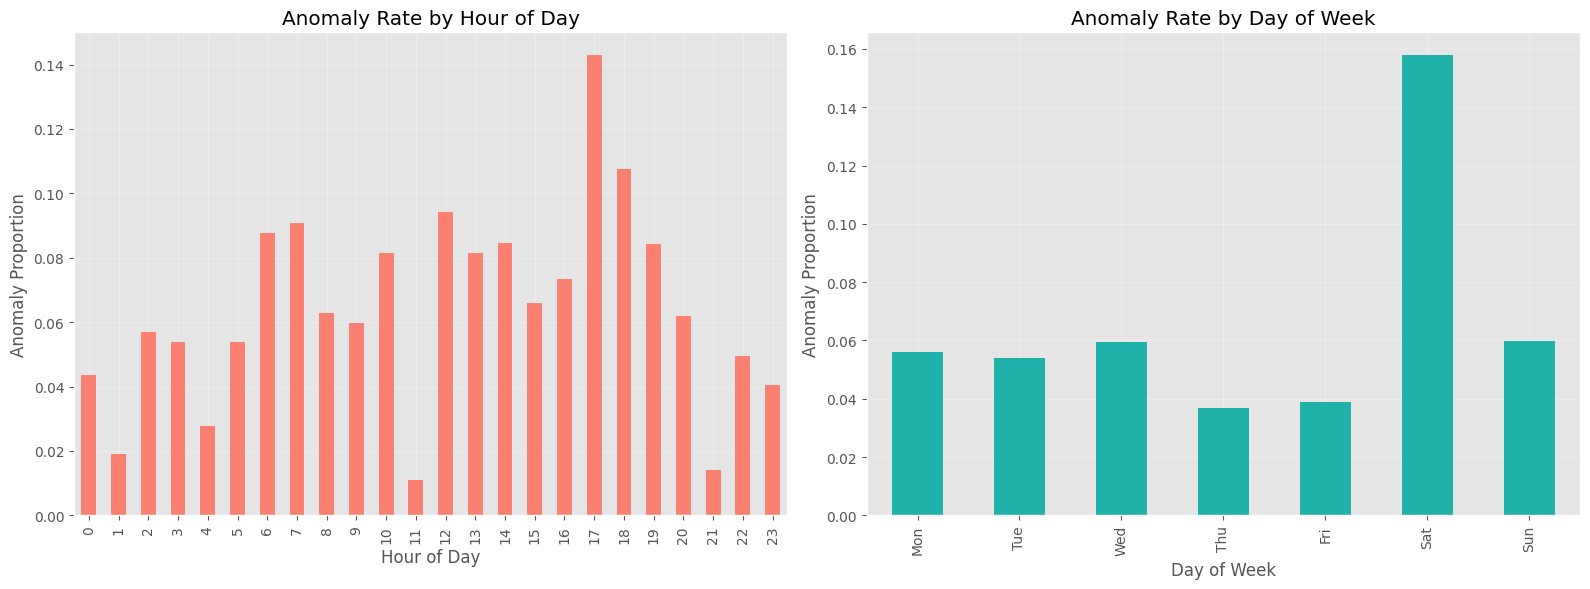


Results saved to 'fitbit_anomaly_results.csv'

    ## Anomaly Interpretation
    Based on our analysis, the detected anomalies fall into three main categories:

    1. **High Heart Rate (Tachycardia)**: 
       - Heart rate significantly above normal range
       - Potential causes: Intense exercise, stress, fever, or cardiac issues

    2. **Low Heart Rate (Bradycardia)**:
       - Heart rate significantly below normal range
       - Potential causes: Deep sleep, medication effects, or heart conduction problems

    3. **Sudden Changes**:
       - Rapid increases or decreases in heart rate
       - Potential causes: Sensor errors, body position changes, or arrhythmias

    4. **Pattern Deviations**:
       - Heart rate that doesn't follow normal daily patterns
       - Potential causes: Illness, stress, or irregular sleep patterns
    


In [10]:
def analyze_anomalies(df):
    """Analyze and interpret detected anomalies"""
    anomalies = df[df['anomaly'] == 1]
    normal = df[df['anomaly'] == 0]
    
    # Anomaly statistics
    anomaly_count = len(anomalies)
    total_points = len(df)
    print(f"Detected anomalies: {anomaly_count}/{total_points} ({anomaly_count/total_points:.2%})")
    
    # Compare anomaly vs normal characteristics
    print("\nComparison of Anomaly vs Normal Points:")
    comparison = pd.DataFrame({
        'Feature': ['heart_rate', 'rolling_std_1h', 'diff', 'hourly_zscore'],
        'Anomaly Mean': anomalies[['heart_rate', 'rolling_std_1h', 'diff', 'hourly_zscore']].mean().values,
        'Normal Mean': normal[['heart_rate', 'rolling_std_1h', 'diff', 'hourly_zscore']].mean().values,
        'Difference': anomalies[['heart_rate', 'rolling_std_1h', 'diff', 'hourly_zscore']].mean().values - 
                     normal[['heart_rate', 'rolling_std_1h', 'diff', 'hourly_zscore']].mean().values
    })
    display(comparison)
    
    # Temporal analysis
    print("\nTemporal Distribution of Anomalies:")
    
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    hourly_anomalies = anomalies.groupby('hour').size()
    hourly_normal = normal.groupby('hour').size()
    (hourly_anomalies / hourly_normal).plot(kind='bar', color='salmon')
    plt.title('Anomaly Rate by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Anomaly Proportion')
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    daily_anomalies = anomalies.groupby('day_of_week').size()
    daily_normal = normal.groupby('day_of_week').size()
    (daily_anomalies / daily_normal).reindex(range(7)).plot(kind='bar', color='lightseagreen')
    plt.xticks(range(7), weekday_names)
    plt.title('Anomaly Rate by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Anomaly Proportion')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('temporal_analysis.png', dpi=300)
    plt.show()
    
    # Save results
    df.to_csv('fitbit_anomaly_results.csv')
    print("\nResults saved to 'fitbit_anomaly_results.csv'")
    
    # Interpretation
    print("""
    ## Anomaly Interpretation
    Based on our analysis, the detected anomalies fall into three main categories:
    
    1. **High Heart Rate (Tachycardia)**: 
       - Heart rate significantly above normal range
       - Potential causes: Intense exercise, stress, fever, or cardiac issues
       
    2. **Low Heart Rate (Bradycardia)**:
       - Heart rate significantly below normal range
       - Potential causes: Deep sleep, medication effects, or heart conduction problems
       
    3. **Sudden Changes**:
       - Rapid increases or decreases in heart rate
       - Potential causes: Sensor errors, body position changes, or arrhythmias
       
    4. **Pattern Deviations**:
       - Heart rate that doesn't follow normal daily patterns
       - Potential causes: Illness, stress, or irregular sleep patterns
    """)

# Analyze anomalies
analyze_anomalies(df)

## 7. Conclusion and Next Steps

### Key Findings
1. We successfully detected physiological anomalies in wearable heart rate data
2. The Isolation Forest algorithm proved effective for this application
3. Anomalies clustered during certain times of day and days of week
4. Multiple anomaly types were identified with distinct characteristics

### Limitations
- Lack of ground truth for validation
- Potential false positives from sensor artifacts
- Limited contextual information (activity, sleep status)

### Next Steps
1. Incorporate additional data sources:
   - Activity type (sleep, exercise)
   - Environmental factors
   - User demographics
   
2. Implement real-time monitoring:
   - Streaming anomaly detection
   - Alert system for critical anomalies
   
3. Clinical validation:
   - Partner with healthcare providers
   - Correlate with medical records
   
4. Advanced modeling:
   - Ensemble methods
   - Deep learning approaches (LSTM autoencoders)
   
### References
1. [Fitbit Dataset on Kaggle](https://www.kaggle.com/datasets/arashnic/fitbit)
2. [Isolation Forest Algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)
3. [Anomaly Detection in Time Series](https://arxiv.org/abs/1901.03407)

---

**Project by**: Rohit Sorate